## Part 2: Clinical Application

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.[1] This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.[2]

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code

In [1]:
# !pip install seaborn==0.9.0

In [2]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [3]:
hr_filenames = glob.glob('/data/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [4]:
metadata_filename = '/data/crisdb/metadata.csv'

# Load the metadata file into this variable.
metadata = pd.read_csv(metadata_filename)

In [5]:
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [6]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 0.05)

    # Find the subject ID from the filename.
    subject_id = filename.split('/')[-1].split('.')[0]

    # Find the age group for this subject in metadata.
    age_group = metadata.query('subject == @subject_id').age.item()
    
    # Find the sex for this subject in metadata.
    sex = metadata.query('subject == @subject_id').sex.item()

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [7]:
df.head()

,age_group,sex,rhr
0,60-64,Female,85.333333
1,65-69,Male,62.924624
2,45-49,Male,52.244898
3,60-64,Male,62.950820
4,50-54,Male,78.771302


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

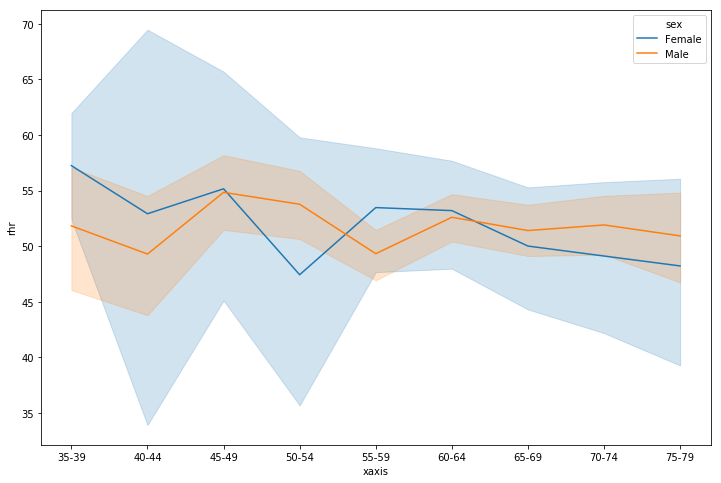

In [9]:
labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

In [11]:
df.sex.value_counts(normalize=True)

Male      0.819779
Female    0.180221
Name: sex, dtype: float64

In [15]:
df.age_group.value_counts(normalize=True).sort_index()

35-39    0.018217
40-44    0.040338
45-49    0.080677
50-54    0.106701
55-59    0.169811
60-64    0.203643
65-69    0.189330
70-74    0.127521
75-79    0.063761
Name: age_group, dtype: float64

### Clinical Conclusion
The RHR of females seem to have a significant uncertainty in the age range of 40-54 years old. In contrast, men's RHR looks more robust across all ages. Its maximum uncertainty is observed for the youngest group, with an error of about 5 BPM.

Over all age ranges, female estimates have more uncertainty that the respective ones on males. That was expected, as there exists a significant imbalance in the sex of the sample. Males represent 82% of the dataset, whereas females represent 18%. A similar issue occurs on the age groups, where younger subjects are underrepresented. For instance, the age group 35-39 encompasses 2% of the dataset and the 60-64 group represents 20%. Thus, the group with more data has a more significant estimate.

A more balanced dataset, including a similar proportion of subjects in each age and sex categories, and taken in different time periods is likely to enhance the results.

The proposition that the average resting heart rate (RHR) increases up until middle age (around 55 years old) and then decreases cannot be validated as the sample of subjects in the ranges 35-54 presents a significant uncertainty and variable results. However, when looking at ages higher than 60 years old, there seems to be a decreasing trend for both males and females. A more structured approach such as hypothesis testing is suggested to evaluate the proposition in further experiments.